In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import torch
import torchvision
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

from torch.utils.data import Dataset, DataLoader
from lr_utils import load_dataset
from tqdm import tqdm

# Dataset creation

In [4]:
class CatorNotCatDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = np.squeeze(y)

    def __getitem__(self,index):
        # dataset with an index
        image = torch.from_numpy(self.x[index])
        label = torch.tensor(self.y[index]).float()
        return image,label
    
    def __len__(self):
        # call length of the dataset
        return len(self.x)

In [5]:
train_x, train_y, test_x, test_y, classes = load_dataset()

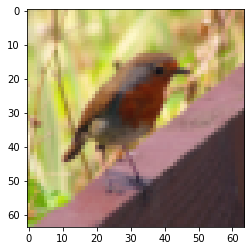

In [6]:
plt.imshow(train_x[10])

In [7]:
# train_x = train_x.reshape(train_x.shape[1]*train_x.shape[2]*train_x.shape[3],train_x.shape[0])
# train_y = np.squeeze(train_y)

# test_x = test_x.reshape(test_x.shape[1]*test_x.shape[2]*test_x.shape[3], test_x.shape[0])
# test_y = np.squeeze(test_y)

In [8]:
train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

In [9]:
train_dataset = CatorNotCatDataset(train_x,train_y)
test_dataset =  CatorNotCatDataset(test_x,test_y)

In [10]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)


# Batching configuration

In [29]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,num_workers=4)

In [30]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self,n_input_features):
        super(LogisticRegression,self).__init__()
        self.linear = nn.Linear(n_input_features,1)
        #self.linear.weight = nn.Parameter(torch.zeros(1,n_input_features))
        #self.linear.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self,x):
        y = torch.sigmoid(self.linear(x))
        print(y)
        return y

In [ ]:
n_features = train_x.shape[1] * train_x.shape[2] * train_x.shape[3]
model = LogisticRegression(n_features)

In [ ]:
learning_rate = 0.001
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50

# Training loop

In [ ]:
metric = torchmetrics.Accuracy()

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for batch_idx,(inputs,labels) in loop:     
        inputs = inputs.reshape(inputs.shape[0],inputs.shape[1]*inputs.shape[2]*inputs.shape[3])
        # Forward pass
        y_predicted = model(inputs)
        y_predicted = y_predicted.reshape(-1)
        loss = criterion(y_predicted,labels)
         # Backward pass
        loss.backward()
        # Accuracy metrics
        acc = metric(y_predicted,labels.int())
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss = loss.item(), accuracy = acc.item()*100)
                
        # updates
        optimizer.step()
        # Reset all gradients
        optimizer.zero_grad()

# Testing loop

In [40]:
metric = torchmetrics.Accuracy()
test_accuracy = []

for inputs,labels in test_loader:
    inputs = inputs.reshape(inputs.shape[0],inputs.shape[1]*inputs.shape[2]*inputs.shape[3])
    y_predicted = model(inputs)
    y_predicted = torch.squeeze(y_predicted).int()
    labels = labels.int()
    acc = metric(y_predicted,labels)
    test_accuracy.append(acc)
    
test_acc = np.mean(test_accuracy)

In [41]:
print(f'Testing accuracy is {test_acc*100:.2f}%')

Testing accuracy is 26.56%
